In [2]:
from typing import Callable, Tuple, Union

from keras.datasets import mnist

from matplotlib import pyplot as plt
import numpy as np

import sklearn.preprocessing
import sklearn.metrics

from tqdm import tqdm

# Наши разработки из 3-ей работы))
from nn import Nums
from nn import NN, Layer
from nn.functions import cross_entropy, dsigmoid, sigmoid, softmax, relu, drelu
from nn.optimizers import AdamOptimizer, OptimizerBase, NoOptimizer, RMSPropOptimizer

from nn.utils import get_indices, add_padding, im2col, col2im

type Nums = np.ndarray[np.number]
type NumsToNums = Callable[[Nums], Nums]
type NumsNumsToNums = Callable[[Nums, Nums], Nums]

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

2024-12-11 15:55:09.580136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733921709.791583  202282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733921709.832033  202282 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 15:55:10.192493: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Загружаем датасет, one-hot-encoding для меток классов

In [30]:
import torch

loss = torch.nn.L1Loss()

input = torch.tensor([0.2, 0.6, 0.2], dtype=torch.float32, requires_grad=True)
target = torch.tensor([0.2, 0.5, 0.3], dtype=torch.float32)

p = loss.forward(input, target)
p.backward()

input.grad

tensor([ 0.0000,  0.3333, -0.3333])

In [29]:
input - target

tensor([ 0.0000,  0.1000, -0.1000], grad_fn=<SubBackward0>)

In [3]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x / 255
test_x = test_x / 255

train_x.resize(60000, 784)
test_x.resize(10000, 784)

encoder = sklearn.preprocessing.OneHotEncoder()
train_y = encoder.fit_transform(train_y[..., None]).toarray()
test_y = encoder.fit_transform(test_y[..., None]).toarray()

train_x.shape, train_y.shape

((60000, 784), (60000, 10))

In [4]:
def get_views(x: Nums, window: Tuple[int, int], strides: Tuple[int, int]) -> Nums:
    """Возвращает view для исходного массива, размерностью [C x M x N x X x Y]

    Окна для свёртки
    
    Args:
        x (Nums): Исходный массив, [C x M x N]
        window (Tuple[int, int]): X x Y
        strides (Tuple[int, int]): Шаги по x и y

    Returns:
        Nums: [C x M x N x X x Y]
    """
    output_shape = (np.subtract(x.shape[-2:], window) + strides) / strides
    output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
    
    # (num_channels) x (output_shape) x (filter size)
    views_shape = (x.shape[0],) + output_shape + window
    
    channel_strides, row_strides, col_strides = x.strides
    
    views = np.lib.stride_tricks.as_strided(
        x, shape=views_shape, strides=(channel_strides, row_strides * strides[0], col_strides * strides[1], row_strides, col_strides)
    )
    return views
    

In [5]:
def add_padding(x: Nums, padding: Tuple[int, int]) -> Nums:
    # accepts 3d array
    return np.pad(x, ((0, 0), (padding[1], padding[1]), (padding[0], padding[0])))

def conv2d(x: Nums, filters: Nums, strides: Tuple[int, int]=(1, 1), padding: Tuple[int, int]=(0, 0)) -> Nums:
    """2д свёртка

    Args:
        x (Nums): Входной массив, 3d [каналы x ширина x высота]
        filters (Nums): Ядра свёртки, 3d [каналы x ширина x высота]
        strides (Tuple[int, int], optional): Шаги свёртки по x и y. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Отступы по x и y. Defaults to (1, 1).

    Returns:
        Nums: Результат свёртки
    """
    assert x.shape[0] == filters.shape[0], f"num channels must be the same, {x.shape[0]} != {filters.shape[0]}"
    if padding != (0, 0):
        x = add_padding(x, padding)
    
    # x - кол-во каналов, x, y
    # filters - кол-во каналов, x, y
    
    output_shape = (np.subtract(x.shape[-2:], filters.shape[-2:]) + strides) / strides
    output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
    
    # (num_channels) x (output_shape) x (filter size)
    views_shape = (x.shape[0],) + output_shape + filters.shape[-2:]
    
    channel_strides, row_strides, col_strides = x.strides
    
    views = np.lib.stride_tricks.as_strided(
        x, shape=views_shape, strides=(channel_strides, row_strides * strides[0], col_strides * strides[1], row_strides, col_strides)
        )
    # print(views, views.shape)
    return np.einsum('cijkl, ckl -> ij', views, filters)

In [6]:
def space_matrix(x, strides):
    shape_x, shape_y = x.shape[-2:]
    shape_x = (shape_x - 1) * strides[0] + 1
    shape_y = (shape_y - 1) * strides[1] + 1
    new_x = np.zeros((x.shape[:-2] + (shape_x, shape_y)))
    new_x[..., ::strides[0], ::strides[1]] = x
    return new_x

In [7]:
class MaxPoolingLayer:
    def __init__(self, window: Tuple[int, int], strides: Tuple[int, int], padding: Tuple[int, int] = (0, 0)):
        self.window = window
        self.strides = strides
        self.padding = padding
        
        self.window_size = self.window[0] * self.window[1]
    
    def forward(self, x):
        assert np.ndim(x) == 3, f"Input must be a 3D array, got {x.shape}"
        
        num_channels = x.shape[0]
        
        # Сколько окон поместится по X и Y (выходная размерность для каждого канала)
        n_H = int((x.shape[1] + 2 * self.padding[0] - self.window[0])/ self.strides[0]) + 1
        n_W = int((x.shape[2] + 2 * self.padding[1] - self.window[1])/ self.strides[1]) + 1
        
        # Переводим окна в 2д матрицу
        x_col = im2col(x, self.window, self.strides, self.padding)
        # Для удобства, делаем 3д (каналы x размер окна x кол-во окон)
        x_col = x_col.reshape(num_channels, self.window_size, -1)
        
        # Делаем пулинг
        a_pol_channeled_flat = np.max(x_col, axis=1)
        a_pol = a_pol_channeled_flat.reshape((num_channels, n_H, n_W))
        
        self.cache = (num_channels, n_H, n_W, x.shape, x_col)
        return a_pol
    
    def backward(self, error):
        num_channels, n_H, n_W, input_shape, x_col = self.cache
        
        assert np.ndim(error) == 3, f"Input must be a 3D array, got {error.shape}"
        assert error.shape[0] == num_channels, \
            f"Num channels must be the same as in forward {error.shape[0]} != {num_channels}"
        
        num_windows = n_H * n_W
        
        indices = np.argmax(x_col, axis=1).reshape((num_channels, n_H, n_W))
        
        filters_indices = np.repeat(np.arange(num_channels), num_windows)
        
        window_indices = np.tile(np.arange(num_windows), num_channels)
        
        # x_col[filters_indices, indices.ravel(), window_indices].reshape((num_channels, -1))
        col_with_error = np.zeros_like(x_col)
        np.add.at(col_with_error, (filters_indices, indices.ravel(), window_indices), error.ravel())
        
        col_with_error = col_with_error.reshape((self.window_size * num_channels, num_windows))
        d_X = col2im(col_with_error, input_shape, self.window, self.strides, self.padding)
        return d_X
        
    def update(self, learning_rate: float):
            pass

    def set_optimizer(self, optimizer: OptimizerBase):
        pass

    def __repr__(self) -> str:
        return f"<Pooling2dLayer>"

In [65]:
class Conv2DLayer:
    """
    Реализует свёрточный слой

    input_size: int - количество входных нейронов
    output_size: int - количество выходных нейронов
    weights: np.ndarray[np.number] - веса слоя
    bias: np.ndarray[np.number] - смещения

    self.activation_function: NumsToNums - функция активации слоя
    self.activation_function_derivation: NumsToNums - производная функции активации слоя
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel: Tuple[int, int],
        strides: Tuple[int, int],
        padding: Tuple[int, int],
        input_shape: Tuple[int, int],
        activation_function: Union[Tuple[
            NumsToNums,
            NumsToNums,
        ], None] = None,
        weights_initialize_function: Callable[[Tuple[int, int]], Nums] = None,
    ) -> None:
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_shape = kernel
        self.input_shape = input_shape
        self.strides = strides
        self.padding = padding
        
        if weights_initialize_function is None:
            weights_initialize_function = np.random.random
        
        self.do_activate = activation_function is not None
        
        if self.do_activate:
            self.activation_function = activation_function[0]
            self.activation_function_derivation = activation_function[1]

        self.weights = weights_initialize_function((out_channels, in_channels, *kernel))
        self.bias = weights_initialize_function((out_channels,))
        
        output_shape = (np.subtract(np.add(input_shape, np.array(padding) * 2), self.kernel_shape) + strides) / strides
        self.output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
        
        self.cache = None
        # self._errors_log = ([], [])
        self.grad_w = np.zeros_like(self.weights)
        self.grad_b = np.zeros_like(self.bias)

    # def forward(self, x: Nums) -> Nums:
    #     assert np.ndim(x) == 3, x.shape

    #     t = np.zeros((self.out_channels, *self.output_shape))
        
    #     for i in range(self.out_channels):
    #         t[i] = conv2d(x, self.weights[i], strides=self.strides, padding=self.padding) + self.bias[i]
        
    #     self.cache = (x, t)
        
    #     if self.do_activate:
    #         h = self.activation_function(t)
    #     else:
    #         h = t
    #     return h
    
    def forward(self, x: Nums):
        assert x.shape[0] == self.in_channels, f"invalid channels count, {x.shape}"
        assert np.ndim(x) == 3, f"invalid shape, expected 3d {x.shape}"
        
        n_H = int((x.shape[1] + 2 * self.padding[0] - self.kernel_shape[0]) / self.strides[0]) + 1
        n_W = int((x.shape[2] + 2 * self.padding[1] - self.kernel_shape[1]) / self.strides[1]) + 1
        
        x_col = im2col(x, self.kernel_shape, self.strides, self.padding)
        
        weights_flatted = self.weights.reshape((self.out_channels, -1))
        bias_flatted = self.bias.reshape((-1, 1))
        
        convolved = (weights_flatted @ x_col) + bias_flatted
        convolved = convolved.reshape((self.out_channels, n_H, n_W))
        
        self.cache = (x_col, convolved)
        
        if self.do_activate:
            h = self.activation_function(convolved)
        else:
            h = convolved
        
        return h

    def backward(self, error: Nums) -> Nums:
        """
        Обратное распространение ошибки
        Запоминает производные ошибки, но не изменяет параметры модели
        Для изменения нужно вызвать update
        """
        assert np.ndim(error) == 3, error.shape
        
        # (8, 11, 11)
        
        x, t = self.cache
        
        if self.do_activate:
            de_dT = error * self.activation_function_derivation(t)
        else:
            de_dT = error
        
        views = get_views(add_padding(x, self.padding), self.kernel_shape, self.strides)
        assert np.ndim(de_dT) == 3, f"invalid shape, {de_dT.shape}"
        
        de_dW = np.einsum('cijkl, oij->ockl', views, de_dT)
        
        de_dB = np.zeros_like(self.bias)
        for i in range(len(de_dT)):
            de_dB[i] = np.sum(de_dT[i])
        
        de_dX = np.zeros(x.shape)
        views_to_write = get_views(de_dX, self.kernel_shape, self.strides)
        views_to_read = get_views(x, self.kernel_shape, self.strides)

        for c in range(len(de_dT)):
            for i in range(views_to_read.shape[1]):
                for j in range(views_to_read.shape[2]):
                    views_to_write[:, i, j] += de_dT[c, i, j] * self.weights[c]
        
        self.grad_w += de_dW
        self.grad_b += de_dB
        # self._errors_log[0].append(de_dW)
        # self._errors_log[1].append(de_dB)
        return de_dX

    def backward(self, error: Nums):
        assert np.ndim(error) == 3, error.shape
        
        x_col, convolved = self.cache
        
        if self.do_activate:
            error = error * self.activation_function_derivation(convolved)
        
        error_reshaped = error.reshape((self.out_channels, -1))
        
        de_dW = (error_reshaped @ x_col.T).reshape(self.weights.shape)
        de_dB = np.sum(error, axis=(1, 2))
        
        weights_flatted = self.weights.reshape((self.out_channels, -1))
        
        error_col = weights_flatted.T @ error_reshaped
        de_dX = col2im(error_col, (self.in_channels, *self.input_shape), self.kernel_shape, self.strides, self.padding)
        
        self.grad_w += de_dW
        self.grad_b += de_dB
        
        return de_dX

    def update(self, learning_rate: float):
        """
        Модифицирует веса модели
        learning_rate: float, [0, 1] - на сколько сильно модель будет реагировать на ошибку
        """
        # de_dWs, de_dBs = self._errors_log
        # de_dW = np.sum(de_dWs, axis=0)
        # de_dB = np.sum(de_dBs, axis=0)

        self.optimizer.step(self.weights, self.bias, learning_rate, self.grad_w, self.grad_b)
        
        self.grad_w = np.zeros_like(self.grad_w)
        self.grad_b = np.zeros_like(self.grad_b)

        # self._errors_log = ([], [])

    def set_optimizer(self, optimizer: OptimizerBase):
        optimizer.init_params(self.weights, self.bias)
        self.optimizer = optimizer

    def __repr__(self) -> str:
        return f"<Conv2dLayer, {self.weights.shape}>"


In [15]:
class FlattenLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, x: Nums) -> Nums:
        return x.reshape((1, x.size))
    
    def backward(self, error: Nums) -> Nums:
        return error.reshape(self.input_size)
    
    def set_optimizer(self, optimizer):
        pass
    
    def update(self, lr):
        pass

In [66]:
# conv1 = Conv2DLayer((5, 3, 3), (1, 1), (1, 1), (relu, drelu), (28, 28))
# pool1 = MaxPool2DLayer((2, 2), (2, 2), (28, 28))
# # conv2 = Conv2DLayer((3, 3, 3), (1, 1), (1, 1), (relu, drelu), (14, 14))
# flat1 = FlattenLayer((5, 14, 14))
# mnn1 = Layer(5 * 14 * 14, 10, (softmax, lambda x: x),
#     weights_initialize_function=lambda shape: np.random.random(shape) * 0.01)



conv1 = Conv2DLayer(1, 8, kernel=(3, 3), strides=(1, 1), padding=(1, 1), input_shape=(28, 28),
                    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01)

pool1 = MaxPoolingLayer(window=(2, 2), strides=(2, 2))

conv2 = Conv2DLayer(8, 8, kernel=(3, 3), strides=(1, 1), padding=(1, 1), input_shape=(14, 14),
            weights_initialize_function=lambda shape: np.random.random(shape) * 0.01)

pool2 = MaxPoolingLayer(window=(2, 2), strides=(2, 2))

flat1 = FlattenLayer((8, 7, 7))
mnn1 = Layer(8 * 7 * 7, 128, (relu, drelu),
    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,
)
mnn2 = Layer(128, 10, (softmax, lambda x: x),
    weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,
)

the_y = train_x[0].reshape((1, 28, 28))

true_y = train_y[0]

print(the_y.shape)

conv1_t = the_y
the_y = conv1.forward(the_y)
print(the_y.shape)

the_y = pool1.forward(the_y)
print("pooled", the_y.shape)

the_y = conv2.forward(the_y)
print(the_y.shape)

the_y = pool2.forward(the_y)
print("pooled", the_y.shape)

the_y = flat1.forward(the_y)
print(the_y.shape)

the_y = mnn1.forward(the_y)
print(the_y.shape)

the_y = mnn2.forward(the_y)
print(the_y.shape)

print("Backwards")

error = the_y - true_y

grad_mnn_2 = mnn2.backward(error)
print("mnn", grad_mnn_2.shape)

grad_mnn = mnn1.backward(grad_mnn_2)
print("mnn", grad_mnn.shape)

grad_unflatten = flat1.backward(grad_mnn)
print("unflatten", grad_unflatten.shape)

grad_pool2 = pool2.backward(grad_unflatten)
print("pool2", grad_pool2.shape)

de_dW2 = conv2.backward(grad_pool2)
print("conv2", de_dW2.shape)

grad_pool1 = pool1.backward(de_dW2)
print("pool1", grad_pool1.shape)

de_dW1 = conv1.backward(grad_pool1)
print("conv1", de_dW1.shape)
# the_y = Conv2DLayer((3, 3, 3), (1, 1), (1, 1), (relu, drelu), (14, 14)).forward(the_y)
# print(the_y.shape)

(1, 28, 28)
(8, 28, 28)
pooled (8, 14, 14)
(8, 14, 14)
pooled (8, 7, 7)
(1, 392)
(1, 128)
(1, 10)
Backwards
mnn (1, 128)
mnn (1, 392)
unflatten (8, 7, 7)
pool2 (8, 14, 14)
conv2 (8, 14, 14)
pool1 (8, 28, 28)
conv1 (1, 28, 28)


In [67]:
class DropoutLayer(Layer):
    def __init__(self, p):
        self.p = p
        
    def forward(self, x):
        self.cache = x
        self.rnd = np.random.uniform(low=0., high=1., size=x.shape) > self.p
        return self.rnd * x
    
    def backward(self, error):
        return self.rnd * error
    
    def set_optimizer(self, optimizer):
        pass
    
    def update(self, learning_rate):
        pass

In [17]:
from nn import NN, Layer
from nn.functions import cross_entropy, dsigmoid, sigmoid, softmax

In [68]:
# expected 95%
from sklearn.metrics import root_mean_squared_error


network = NN(
    [
        MaxPoolingLayer(window=(2, 2), strides=(2, 2)),
        
        Conv2DLayer(1, 32, kernel=(3, 3), strides=(1, 1), padding=(1, 1), input_shape=(14, 14),
                    activation_function=(relu, drelu),
                    weights_initialize_function=lambda shape: np.random.rand(*shape) * 0.1),
        
        MaxPoolingLayer(window=(2, 2), strides=(2, 2)),
        
        # Conv2DLayer(32, 16, kernel=(3, 3), strides=(1, 1), padding=(1, 1), input_shape=(7, 7),
        #             activation_function=(relu, drelu),
        #             weights_initialize_function=lambda shape: np.random.rand(*shape) * 0.01),
        
        # MaxPool2DLayer(kernel=(2, 2), strides=(2, 2)),
        
        # FlattenLayer((64, 5, 5)),
        # MaxPool2DLayer(kernel=(2, 2), strides=(2, 2)),
        FlattenLayer((32, 7, 7)),
        # Layer(64 * 6 * 6, 128, (relu, drelu),
        #     weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,
        # ),
        
        # FlattenLayer((1, 28, 28)),
        Layer(32 * 7 * 7, 64, (relu, drelu),
              weights_initialize_function=lambda shape: np.random.random(shape) * 0.1,),
        DropoutLayer(0.2),
        Layer(64, 10, (softmax, lambda x: x),
            weights_initialize_function=lambda shape: np.random.random(shape) * 0.1,
        ),
    ],
    loss_function=cross_entropy,
)

loss_history = []

In [69]:
network.forward(train_x[0].reshape((1, 28, 28)))

array([[0.000, 0.001, 0.926, 0.001, 0.000, 0.003, 0.063, 0.001, 0.000,
        0.004]])

In [28]:
%load_ext pyinstrument

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


In [77]:
def train(
    network: NN,
    x: Nums,
    y: Nums,
    num_epoches: int,
    learning_rate: float,
    batch_size: int,
    loss_history: list
):
    bar = tqdm(range(1, num_epoches + 1), total=num_epoches)
    xy_indices = np.arange(len(x))
    for epoch in bar:
        network.predicted.clear()
        # В каждой эпохе изменим порядок обучающего датасета
        np.random.shuffle(xy_indices)

        # size - размер выборки для эпохи, ставлю 1000, чтобы быстрее видеть результат
        indices = np.random.choice(len(xy_indices), size=100, replace=False)

        epoch_x = x[indices]
        epoch_y = y[indices]
        
        network.train(
            epoch_x,
            epoch_y,
            lambda: AdamOptimizer(0.4, 0.999),
            learning_rate=learning_rate,
            batch_size=batch_size,
        )
        
        # Средний loss за эпоху
        loss = network.pop_loss(np.mean)
        loss_history.append(loss)

        bar.set_description(
            f"epoch: {epoch}, loss: {loss:.10f}"
        )
        network.losses.clear()
    return loss_history

loss_history = train(
    network, train_x.reshape((60000, 1, 28, 28)), train_y, 100, 0.003, 25, loss_history
)

epoch: 100, loss: 7.4519181774: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


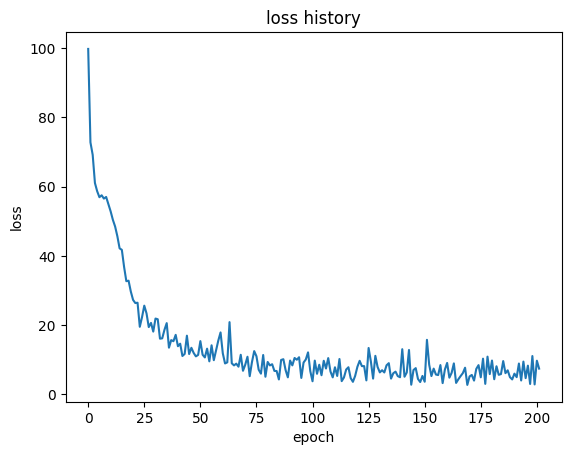

In [78]:
fig, ax = plt.subplots()

ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("loss history")
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       980
           1       0.98      0.97      0.98      1135
           2       0.92      0.95      0.94      1032
           3       0.94      0.92      0.93      1010
           4       0.95      0.93      0.94       982
           5       0.96      0.92      0.94       892
           6       0.97      0.96      0.96       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.95      0.91       974
           9       0.91      0.93      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



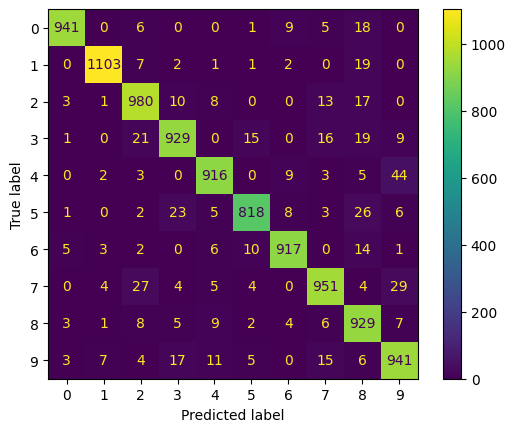

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = []
for i in range(len(test_x)):
    y_pred.append(network.forward(test_x[i].reshape((1, 28, 28)))[0])

y_pred_classes = [x for x in np.argmax(y_pred, axis=1)]
y_true_classes = [x for x in np.argmax(test_y, axis=1)]

print(sklearn.metrics.classification_report(y_true_classes, y_pred_classes))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)

In [ ]:
def show_multiple(images):
    # plot images
    fig, axes = plt.subplots(1, len(images), figsize=(1.5*len(images),2))
    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')

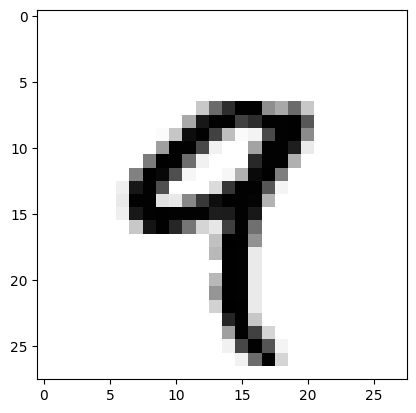

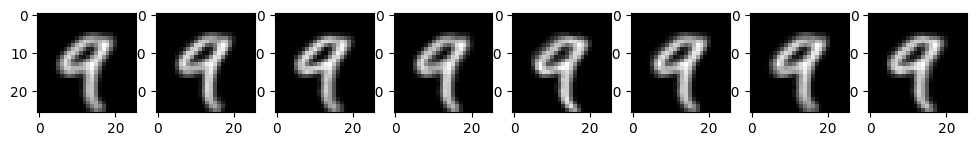

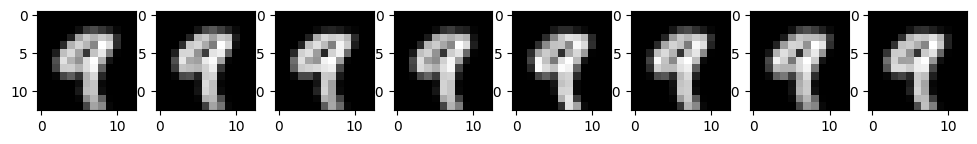

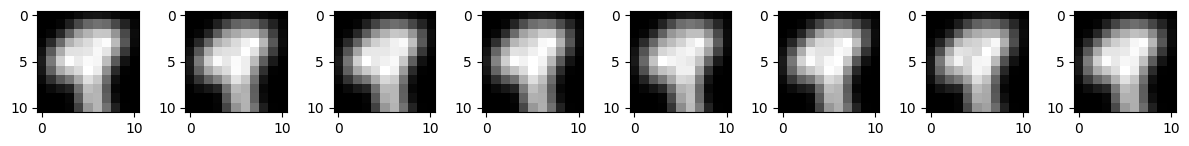

In [ ]:
sample = train_x[4].reshape((1, 28, 28))

fig = plt.figure
plt.imshow(sample[0], cmap='gray_r')
plt.show()

after_conv_1 = network.layers[0].forward(sample)
show_multiple(after_conv_1)
after_max = network.layers[1].forward(after_conv_1)
show_multiple(after_max)
after_conv_2 = network.layers[2].forward(after_max)
show_multiple(after_conv_2)
# after_max_2 = network.layers[3].forward(after_conv_2)
# show_multiple(after_max_2)

plt.tight_layout()
plt.show()


In [ ]:
def forward_conv(self, X):
    """
        Performs a forward convolution.

        Parameters:
        - X : Last conv layer of shape (m, n_C_prev, n_H_prev, n_W_prev).

        Returns:
        - out: output of convolution.
    """
    self.cache = X
    m, n_C_prev, n_H_prev, n_W_prev = X.shape

    # Define output size.
    n_C = self.n_F
    n_H = int((n_H_prev + 2 * self.p - self.f)/ self.s) + 1
    n_W = int((n_W_prev + 2 * self.p - self.f)/ self.s) + 1

    out = np.zeros((m, n_C, n_H, n_W))

    for i in range(m): # For each image.

        for c in range(n_C): # For each channel.

            for h in range(n_H): # Slide the filter vertically.
                h_start = h * self.s
                h_end = h_start + self.f

                for w in range(n_W): # Slide the filter horizontally.                
                    w_start = w * self.s
                    w_end = w_start + self.f

                    # Element wise multiplication + sum.
                    out[i, c, h, w] = np.sum(X[i, :, h_start:h_end, w_start:w_end] 
                                    * self.W['val'][c, ...]) + self.b['val'][c]
    return out

In [ ]:
def backward(self, dout):
    """
        Distributes error from previous layer to convolutional layer and
        compute error for the current convolutional layer.
        Parameters:
        - dout: error from previous layer.

        Returns:
        - deltaL: error of the current convolutional layer.
    """
    X = self.cache

    m, n_C, n_H, n_W = X.shape
    m, n_C_dout, n_H_dout, n_W_dout = dout.shape

    dX = np.zeros(X.shape)

    #Compute dW.
    for i in range(m): # For each example.

        for c in range(n_C_dout): # For each channel.

            for h in range(n_H_dout): # Slide the filter vertically.
                h_start = h * self.s
                h_end = h_start + self.f

                for w in range(n_W_dout): #  Slide the filter horizontally.
                    w_start = w * self.s
                    w_end = w_start + self.f

                    self.W['grad'][c, ...] += dout[i, c, h, w] * X[i, :, h_start:h_end, w_start:w_end]
                    dX[i, :, h_start:h_end, w_start:w_end] += dout[i, c, h, w] * self.W['val'][c, ...]
    #Compute db.
    for c in range(self.n_F):
        self.b['grad'][c, ...] = np.sum(dout[:, c, ...])

    return dX, self.W['grad'], self.b['grad']

In [ ]:
from numpy import flip


class A:
    pass

weights = np.array([
    [
        [0, 1, 0],
        [1, 0, 1],
        [2, 1, 0]
    ],
    [
        [0, 1, 0],
        [1, 0, 1],
        [2, 1, 0]
    ]
])

weights = np.array([weights, flip(weights), weights, flip(weights)])
bias = np.ones((len(weights),))

obj = A()
obj.n_F = 4  # num filters
obj.s = 1  # strides
obj.f = 3  # kernel shape
obj.p = 0  # padding
obj.W = {'val': weights, 'grad': np.zeros_like(weights, dtype=np.float64)}
obj.b = {'val': bias, 'grad': np.zeros_like(bias, dtype=np.float64)}
weights.shape

(4, 2, 3, 3)

In [ ]:
test_a = np.array([
    [
        [0, 1, 2, 1, 0],
        [4, 1, 0, 1, 0],
        [2, 0, 1, 1, 1],
        [1, 2, 3, 1, 0],
        [0, 4, 3, 2, 0],
    ],
    np.flip(np.array([
        [0, 1, 2, 1, 0],
        [4, 1, 0, 1, 0],
        [2, 0, 1, 1, 1],
        [1, 2, 3, 1, 0],
        [0, 4, 3, 2, 0],
    ])),
])
# display(test_a)

fwd = forward_conv(obj, test_a.reshape((1, 2, 5, 5)))
# display(fwd, fwd.shape)

y = relu(fwd)

error = np.random.randint(1, 100, size=y.shape)
# error = np.ones_like(y)[0]
print("error_shape", error.shape)

de_dT = error * drelu(fwd)

print("grad to prev layer")
dx_true, dw_true, db_true = backward(obj, de_dT)
# de_dT = de_dT[0]

l = Conv2DLayer(2, 4, (3, 3), (1, 1), (0, 0), (5, 5), (relu, drelu))
l.weights = weights
l.bias = obj.b['val']
q = l.forward(test_a.reshape(2, 5, 5))
print("shape", error.shape)
dx = l.backward(error[0])
# dw, db = l._errors_log
# q

error_shape (1, 4, 3, 3)
grad to prev layer
shape (1, 4, 3, 3)


ValueError: operands could not be broadcast together with shapes (4,2,5,5) (4,2,3,3) (4,2,5,5) 

In [ ]:
layer = MaxPool2DLayer((2, 2), (2, 2))
pooled = layer.forward(q)
layer.backward(np.ones_like(pooled))
# views = get_views(q, (2, 2), (2, 2))
# t = np.max(views, axis=(-2, -1))

# pooled, pooled.shape, views.shape

array([[[1.000, 0.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]],

       [[0.000, 1.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]],

       [[1.000, 0.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]],

       [[0.000, 1.000, 0.000],
        [0.000, 0.000, 0.000],
        [0.000, 0.000, 0.000]]])

In [ ]:
error = np.ones_like(pooled)
error

array([[[1.000]],

       [[1.000]],

       [[1.000]],

       [[1.000]]])

In [ ]:
views.shape

(2, 5, 5, 3, 3)

In [ ]:
class Maxpool():

    def __init__(self,X_dim,size,stride):

        self.d_X, self.h_X, self.w_X = X_dim

        self.params = []

        self.size = size
        self.stride = stride

        self.h_out = (self.h_X - size)/stride + 1
        self.w_out = (self.w_X - size)/stride + 1


        if not self.h_out.is_integer() or not self.w_out.is_integer():
            raise Exception("Invalid dimensions!")

        self.h_out,self.w_out  = int(self.h_out), int(self.w_out)
        self.out_dim = (self.d_X,self.h_out,self.w_out)

    def forward(self,X):
        self.n_X = X.shape[0]
        X_reshaped = X.reshape(X.shape[0]*X.shape[1],1,X.shape[2],X.shape[3])

        self.X_col = im2col_indices(X_reshaped, self.size, self.size, padding = 0, stride = self.stride)

        self.max_indexes = np.argmax(self.X_col,axis=0)
        out = self.X_col[self.max_indexes,range(self.max_indexes.size)]

        out = out.reshape(self.h_out,self.w_out,self.n_X,self.d_X).transpose(2,3,0,1)
        return out

    def backward(self,dout):

        dX_col = np.zeros_like(self.X_col)
        # flatten the gradient
        dout_flat = dout.transpose(2,3,0,1).ravel()

        dX_col[self.max_indexes,range(self.max_indexes.size)] = dout_flat

        # get the original X_reshaped structure from col2im
        shape = (self.n_X*self.d_X,1,self.h_X,self.w_X)
        dX = col2im_indices(dX_col,shape,self.size,self.size,padding=0,stride=self.stride)
        dX = dX.reshape(self.n_X,self.d_X,self.h_X,self.w_X)
        return dX,[]

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:49:39  Samples:  1
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.001     CPU time: 0.001
/   _/                      v5.0.0

Cell [543]

0.001 <module>  /tmp/ipykernel_348362/800481996.py:1
`- 0.001 argmax  numpy/_core/fromnumeric.py:1268
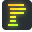

In [ ]:
%%pyinstrument

de_dX = np.zeros((4, 3, 3))
views_to_write = get_views(de_dX, (2, 2), (2, 2))
views_to_read = get_views(q, (2, 2), (2, 2))

for c in range(len(views_to_read)):
    for i in range(views_to_read.shape[1]):
        for j in range(views_to_read.shape[2]):
            idx = np.argmax(views_to_read[c, i, j])
            views_to_write[c, i, j][np.unravel_index(idx, (2, 2))] += error[c, i, j]

In [ ]:
obj.W['grad'] = np.zeros_like(obj.W['val'], dtype=np.float64)
obj.b['grad'] = np.zeros_like(obj.b['val'], dtype=np.float64)
_, dw, _ = backward(obj, de_dT)
dw

array([[[[413.000, 321.000, 279.000],
         [464.000, 307.000, 305.000],
         [507.000, 612.000, 391.000]],

        [[523.000, 754.000, 712.000],
         [317.000, 482.000, 556.000],
         [290.000, 254.000, 415.000]]],


       [[[339.000, 323.000, 355.000],
         [676.000, 512.000, 209.000],
         [950.000, 730.000, 355.000]],

        [[561.000, 784.000, 598.000],
         [380.000, 388.000, 751.000],
         [441.000, 314.000, 506.000]]],


       [[[629.000, 456.000, 344.000],
         [575.000, 407.000, 367.000],
         [670.000, 849.000, 522.000]],

        [[746.000, 1039.000, 918.000],
         [502.000, 713.000, 760.000],
         [446.000, 325.000, 474.000]]],


       [[[745.000, 300.000, 264.000],
         [525.000, 541.000, 473.000],
         [790.000, 1033.000, 786.000]],

        [[536.000, 877.000, 654.000],
         [494.000, 413.000, 394.000],
         [262.000, 359.000, 568.000]]]])

In [ ]:
de_dT.shape, weights.shape

((1, 4, 3, 3), (4, 2, 3, 3))

In [ ]:
de_dX = np.zeros(test_a.shape)
views_to_write = get_views(de_dX, weights.shape[2:], (1, 1))
views_to_read = get_views(test_a, weights.shape[2:], (1, 1))

for c in range(len(de_dT[0])):
    for i in range(views_to_read.shape[1]):
        for j in range(views_to_read.shape[2]):
            views_to_write[:, i, j] += de_dT[0, c, i, j] * weights[c]

de_dX

array([[[0.000, 133.000, 329.000, 277.000, 262.000],
        [133.000, 330.000, 896.000, 661.000, 415.000],
        [267.000, 911.000, 1008.000, 1018.000, 338.000],
        [252.000, 545.000, 795.000, 284.000, 217.000],
        [162.000, 184.000, 380.000, 217.000, 0.000]],

       [[0.000, 133.000, 329.000, 277.000, 262.000],
        [133.000, 330.000, 896.000, 661.000, 415.000],
        [267.000, 911.000, 1008.000, 1018.000, 338.000],
        [252.000, 545.000, 795.000, 284.000, 217.000],
        [162.000, 184.000, 380.000, 217.000, 0.000]]])

In [ ]:
de_dX = np.zeros(test_a.shape)
views_to_write = get_views(de_dX, weights.shape[2:], (1, 1))
views_to_read = get_views(test_a, weights.shape[2:], (1, 1))

for i in range(views_to_read.shape[1]):
    for j in range(views_to_read.shape[2]):
        views_to_write[:, i, j] += de_dT[0, :, i, j] * weights[:]

de_dX

ValueError: operands could not be broadcast together with shapes (4,) (4,2,3,3) 

In [ ]:
w0 = weights[0]

In [ ]:
import jax.numpy as jnp

In [ ]:
views = get_views(add_padding(w0, (2, 2)), (3, 3), (1, 1))
print(views.shape)
import time
# out = np.zeros((2, 5, 5))

# for c in range(len(de_dT[0])):
#     for i in range(views.shape[1]):
#         for j in range(views.shape[2]):
#             out[c, ...] += views[:, i, j] * de_dT[0, c, i, j]
# out
t0 = time.time()
for i in range(1000):
    jnp.einsum('cijkl, okl->cij', views, de_dT[0])
print(time.time() - t0)
# print(np.einsum_path('cijkl, okl->cij', views, de_dT[0], optimize='greedly')[1])
# print(views.shape, de_dT[0].shape)
# out, out.shape

(2, 5, 5, 3, 3)
0.25749635696411133


In [ ]:
views.shape

(2, 3, 3, 3, 3)

In [ ]:
for c in range(len(de_dT[0])):
    print(np.sum(de_dT[0, c]))

np.sum(de_dT[0], axis=0)

448
436
527
427


array([[190, 165, 133],
       [231, 151, 286],
       [221, 186, 275]])

In [ ]:
views = get_views(test_a, (3, 3), (1, 1))

out = np.zeros((4, 2, 3, 3))

for c in range(len(de_dT[0])):
    for i in range(views.shape[1]):
        for j in range(views.shape[2]):
            out[c, ...] += views[:, i, j] * de_dT[0, c, i, j]
out
assert (np.einsum('cijkl, oij->ockl', views, de_dT[0]) == out).all()
print(views.shape, de_dT[0].shape)
out, out.shape

(2, 3, 3, 3, 3) (4, 3, 3)


(array([[[[639.000, 411.000, 234.000],
          [635.000, 495.000, 400.000],
          [871.000, 874.000, 608.000]],
 
         [[676.000, 787.000, 686.000],
          [466.000, 432.000, 679.000],
          [305.000, 417.000, 622.000]]],
 
 
        [[[535.000, 380.000, 296.000],
          [741.000, 411.000, 320.000],
          [869.000, 732.000, 466.000]],
 
         [[601.000, 762.000, 799.000],
          [359.000, 412.000, 809.000],
          [332.000, 362.000, 615.000]]],
 
 
        [[[514.000, 378.000, 413.000],
          [823.000, 756.000, 587.000],
          [1157.000, 1211.000, 701.000]],
 
         [[694.000, 793.000, 748.000],
          [353.000, 376.000, 770.000],
          [378.000, 536.000, 799.000]]],
 
 
        [[[535.000, 462.000, 435.000],
          [892.000, 373.000, 375.000],
          [576.000, 674.000, 592.000]],
 
         [[449.000, 728.000, 1049.000],
          [240.000, 609.000, 864.000],
          [360.000, 425.000, 343.000]]]]),
 (4, 2, 3, 3))

In [ ]:
np.einsum('cijkl, oij->ockl', views, de_dT[0])

array([[[[ 639,  411,  234],
         [ 635,  495,  400],
         [ 871,  874,  608]],

        [[ 676,  787,  686],
         [ 466,  432,  679],
         [ 305,  417,  622]]],


       [[[ 535,  380,  296],
         [ 741,  411,  320],
         [ 869,  732,  466]],

        [[ 601,  762,  799],
         [ 359,  412,  809],
         [ 332,  362,  615]]],


       [[[ 514,  378,  413],
         [ 823,  756,  587],
         [1157, 1211,  701]],

        [[ 694,  793,  748],
         [ 353,  376,  770],
         [ 378,  536,  799]]],


       [[[ 535,  462,  435],
         [ 892,  373,  375],
         [ 576,  674,  592]],

        [[ 449,  728, 1049],
         [ 240,  609,  864],
         [ 360,  425,  343]]]])

In [ ]:
# def add_padding(x: Nums, padding: Tuple[int, int]) -> Nums:
#     # accepts 3d array
#     return np.pad(x, ((0, 0), (padding[1], padding[1]), (padding[0], padding[0])))

# def conv2d(x: Nums, filters: Nums, strides: Tuple[int, int]=(1, 1), padding: Tuple[int, int]=(0, 0)) -> Nums:
#     """2д свёртка

#     Args:
#         x (Nums): Входной массив, 3d
#         filters (Nums): Ядра свёртки, 3d
#         strides (Tuple[int, int], optional): Шаги свёртки по x и y. Defaults to (1, 1).
#         padding (Tuple[int, int], optional): Отступы по x и y. Defaults to (1, 1).

#     Returns:
#         Nums: Результат свёртки
#     """
#     assert x.shape[0] == filters.shape[0], f"num channels must be the same, {x.shape[0]} != {filters.shape[0]}"
#     if padding != (0, 0):
#         x = add_padding(x, padding)
    
#     # x - кол-во каналов, x, y
#     # filters - кол-во каналов, x, y
    
#     output_shape = (np.subtract(x.shape[-2:], filters.shape[-2:]) + strides) / strides
#     output_shape = tuple(np.floor(output_shape, casting='unsafe', dtype=int))
    
#     # (num_channels) x (output_shape) x (filter size)
#     views_shape = (x.shape[0],) + output_shape + filters.shape[-2:]
    
#     print(views_shape)
#     # 2 x 3 x 3
    
#     channel_strides, row_strides, col_strides = x.strides
#     print((channel_strides, row_strides * strides[0], col_strides * strides[1], row_strides, col_strides))
    
#     views = np.lib.stride_tricks.as_strided(
#         x, shape=views_shape, strides=(channel_strides, row_strides * strides[0], col_strides * strides[1], row_strides, col_strides)
#         )
#     # print(views, views.shape)
#     return np.einsum('cijkl, ckl -> ij', views, filters)

In [ ]:
# Допустим есть 2 канала 5 на 5
test_a.shape

(2, 5, 5)

In [ ]:
# Допустим есть 2 фильтра (2x3x3)
weights.shape

(2, 2, 3, 3)

In [ ]:
output = np.zeros((2, 3, 3))

for i in range(len(weights)):
    output[i] = conv2d(test_a, weights[i], strides=(1, 1), padding=(0, 0))

(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)
(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)
(2, np.int64(3), np.int64(3), 3, 3)
(200, 40, 8, 40, 8)


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
output

array([[[17.000, 14.000, 14.000],
        [12.000, 14.000, 16.000],
        [10.000, 22.000, 21.000]],

       [[21.000, 22.000, 10.000],
        [16.000, 14.000, 12.000],
        [14.000, 14.000, 17.000]]])

In [ ]:
# %%pyinstrument
for i in range(100):
    network.forward(test_x[i].reshape((1, 28, 28)))[0]